## Обработка графиков ЭКГ и преобразование в таблицу

In [1]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
#from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

In [618]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [619]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [620]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-3])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 10.3 s
Wall time: 10.3 s


In [621]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'record_name'})

In [622]:
ECG_data = ECG_data.sort_values(by=['record_name'], ascending=True)

In [623]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## Объединение таблиц, разбиение на тренировочную и валидационную выборки

In [624]:
df = pd.read_csv('train/train_meta.csv')
df.record_name = list(map(lambda x: int(x.strip('_hr')), df.record_name))
df

,patient_id,age,sex,height,weight,record_name
0,18792.0,55.0,0,NaN,70.0,9
1,13619.0,56.0,0,NaN,NaN,34
2,11315.0,25.0,1,NaN,63.0,43
3,18153.0,35.0,0,NaN,82.0,52
4,16063.0,26.0,0,NaN,93.0,57
...,...,...,...,...,...,...
2096,12488.0,66.0,1,NaN,NaN,21784
2097,10162.0,68.0,0,NaN,NaN,21795
2098,11197.0,59.0,0,NaN,NaN,21825
2099,11905.0,55.0,1,NaN,NaN,21831


In [625]:
ECG_data = ECG_data.merge(df, on='record_name', how='left')

In [626]:
gts = pd.read_csv('train/train_gts_final.csv')
gts.record_name = list(map(lambda x: int(x.strip('_hr')), gts.record_name))
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма,record_name
0,0,0,0,0,0,0,1,669
1,0,0,0,0,0,0,1,209
2,0,0,0,0,0,0,1,777
3,0,0,0,0,0,0,1,1394
4,0,0,0,0,0,0,1,1618
...,...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1,20864
2097,0,0,0,0,0,0,1,20967
2098,0,0,0,0,0,0,1,21744
2099,0,0,0,0,0,0,1,3465


In [627]:
ECG_data = ECG_data.merge(gts, on='record_name', how='left')

In [628]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,sex,height,weight,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0,NaN,70.0,0,0,0,0,0,0,1
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,0,NaN,NaN,0,0,0,0,0,0,1
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,1,NaN,63.0,0,0,0,0,0,0,1
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,0,NaN,82.0,0,0,0,0,0,0,1
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,0,NaN,93.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,1,NaN,NaN,0,0,0,0,0,0,1
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0,NaN,NaN,0,0,0,0,0,0,1
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,0,NaN,NaN,0,0,0,0,0,0,1
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,1,NaN,NaN,0,0,0,0,0,0,1


In [629]:
gts = ECG_data[['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный', 'нижний', 'норма']]
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1
2097,0,0,0,0,0,0,1
2098,0,0,0,0,0,0,1
2099,0,0,0,0,0,0,1


In [630]:
ECG_data = ECG_data.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой',
                          'передне-перегородочный', 'нижний', 'норма'], axis=1)

In [631]:
ECG_data_train, ECG_data_val, myocard_train, myocard_val = train_test_split(ECG_data, gts, random_state=0)

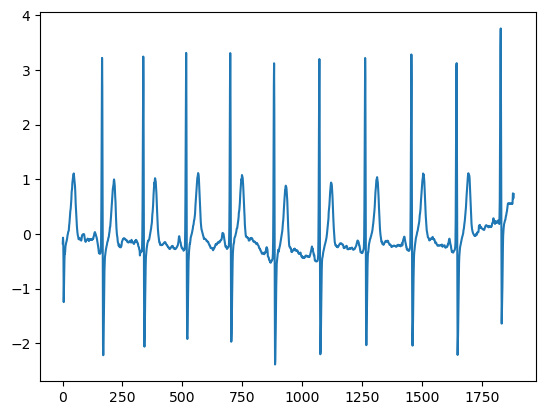

In [632]:
plt.plot(ECG_data.iloc[0, 1:-5]) # график экг после обработки сигнала

In [633]:
df_train = ECG_data_train.iloc[:, -5:]
df_val = ECG_data_val.iloc[:, -5:]

In [634]:
df_train

,patient_id,age,sex,height,weight
1592,4964.0,22.0,1,163.0,90.0
918,16196.0,84.0,0,NaN,NaN
122,767.0,61.0,0,183.0,83.0
684,12056.0,74.0,1,NaN,NaN
214,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN
1731,4102.0,64.0,1,168.0,66.0
763,10524.0,34.0,0,NaN,72.0
835,10717.0,55.0,0,NaN,NaN


In [217]:
ECG_data_train = ECG_data_train.iloc[:, :-5]
ECG_data_val = ECG_data_val.iloc[:, :-5]

In [218]:
ECG_data_train

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1592,16603,0.109449,0.185223,0.125672,-0.151371,-0.829218,-0.622236,-0.656209,-0.655158,-0.620203,...,-0.276397,-0.271167,-0.271356,-0.278988,-0.276562,-0.365569,-0.453599,-0.369220,-0.385059,-0.441318
918,9557,-1.490900,-1.394463,-1.459593,-1.758585,-2.413724,-2.193418,-1.980952,-1.772527,-1.498688,...,1.808763,1.794004,1.791578,1.824338,1.824525,2.338546,2.856921,2.381495,2.466389,2.781295
122,1511,0.410295,0.418111,0.411441,0.385160,0.316728,0.322976,0.268045,0.196556,0.132210,...,0.429139,0.419976,0.423895,0.435734,0.434976,0.667413,0.897665,0.677479,0.718923,0.865508
684,7125,-0.121402,-0.121375,-0.120977,-0.119733,-0.114203,-0.115726,-0.117201,-0.126269,-0.128501,...,0.680528,0.667779,0.672897,0.689272,0.687265,0.994409,1.308699,1.007843,1.064270,1.265372
214,2316,0.028528,-0.025202,0.009788,0.172212,0.546162,0.536875,1.251363,2.411523,3.051960,...,-0.384466,-0.378909,-0.380860,-0.388554,-0.387973,-0.530641,-0.673326,-0.537565,-0.562936,-0.653343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,10677,1.348874,1.394465,1.405025,1.479370,1.920034,1.547778,0.474275,-0.755991,-1.562751,...,-0.187951,-0.184040,-0.186707,-0.190465,-0.189940,-0.280883,-0.378106,-0.283582,-0.301543,-0.365178
1731,18020,-0.285911,-0.265134,-0.282379,-0.365458,-0.574443,-0.503349,-0.498727,-0.482626,-0.459739,...,-0.247702,-0.239041,-0.247471,-0.255108,-0.257066,-0.526102,-0.801259,-0.535676,-0.586126,-0.763746
763,7978,-0.316812,-0.305549,-0.314139,-0.357382,-0.462342,-0.426322,-0.437142,-0.429418,-0.412790,...,-0.151037,-0.149981,-0.150161,-0.152364,-0.152745,-0.197529,-0.242362,-0.200993,-0.208471,-0.235857
835,8797,-0.897106,-0.901242,-0.897541,-0.887869,-0.862189,-0.857458,-0.841005,-0.826645,-0.800221,...,0.142141,0.140497,0.141669,0.143489,0.143677,0.191975,0.240699,0.193946,0.202788,0.233976


## N-граммы

In [219]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from catboost import CatBoostClassifier

In [220]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [221]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [222]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [223]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [224]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [225]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [226]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [227]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    # н-граммы, встречающиеся только в этой категории
    ng_healthy = sum(list(map(lambda x: 1 if x in only_healthy else 0, ng))) 
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))
    
    ng_septal_0 = sum(list(map(lambda x: 1 if x in only_septal_0 else 0, ng)))
    ng_septal_1 = sum(list(map(lambda x: 1 if x in only_septal_1 else 0, ng)))
    
    ng_front_0 = sum(list(map(lambda x: 1 if x in only_front_0 else 0, ng)))
    ng_front_1 = sum(list(map(lambda x: 1 if x in only_front_1 else 0, ng)))
    
    ng_side_0 = sum(list(map(lambda x: 1 if x in only_side_0 else 0, ng)))
    ng_side_1 = sum(list(map(lambda x: 1 if x in only_side_1 else 0, ng)))
    
    ng_front_side_0 = sum(list(map(lambda x: 1 if x in only_front_side_0 else 0, ng)))
    ng_front_side_1 = sum(list(map(lambda x: 1 if x in only_front_side_1 else 0, ng)))
    
    ng_front_septal_0 = sum(list(map(lambda x: 1 if x in only_front_septal_0 else 0, ng)))
    ng_front_septal_1 = sum(list(map(lambda x: 1 if x in only_front_septal_1 else 0, ng)))
    
    ng_lower_0 = sum(list(map(lambda x: 1 if x in only_lower_0 else 0, ng)))
    ng_lower_1 = sum(list(map(lambda x: 1 if x in only_lower_1 else 0, ng)))
    
    # н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
    ng_popular_healthy = sum(list(map(lambda x: 1 if x in popular_healthy_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))
    
    ng_popular_septal_0 = sum(list(map(lambda x: 1 if x in popular_septal_0_only else 0, ng)))
    ng_popular_septal_1 = sum(list(map(lambda x: 1 if x in popular_septal_1_only else 0, ng)))
    
    ng_popular_front_0 = sum(list(map(lambda x: 1 if x in popular_front_0_only else 0, ng)))
    ng_popular_front_1 = sum(list(map(lambda x: 1 if x in popular_front_1_only else 0, ng)))
    
    ng_popular_side_0 = sum(list(map(lambda x: 1 if x in popular_side_0_only else 0, ng)))
    ng_popular_side_1 = sum(list(map(lambda x: 1 if x in popular_side_1_only else 0, ng)))
    
    ng_popular_front_side_0 = sum(list(map(lambda x: 1 if x in popular_front_side_0_only else 0, ng)))
    ng_popular_front_side_1 = sum(list(map(lambda x: 1 if x in popular_front_side_1_only else 0, ng)))
    
    ng_popular_front_septal_0 = sum(list(map(lambda x: 1 if x in popular_front_septal_0_only else 0, ng)))
    ng_popular_front_septal_1 = sum(list(map(lambda x: 1 if x in popular_front_septal_1_only else 0, ng)))
    
    ng_popular_lower_0 = sum(list(map(lambda x: 1 if x in popular_lower_0_only else 0, ng)))
    ng_popular_lower_1 = sum(list(map(lambda x: 1 if x in popular_lower_1_only else 0, ng)))
    
    return array([[ng_healthy, ng_popular_healthy, ng_sick, ng_popular_sick],
                  [ng_septal_0, ng_popular_septal_0, ng_septal_1, ng_popular_septal_1],
                  [ng_front_0, ng_popular_front_0, ng_front_1, ng_popular_front_1],
                  [ng_side_0, ng_popular_side_0, ng_side_1, ng_popular_side_1],
                  [ng_front_side_0, ng_popular_front_side_0, ng_front_side_1, ng_popular_front_side_1],
                  [ng_front_septal_0, ng_popular_front_septal_0, ng_front_septal_1, ng_popular_front_septal_1],
                  [ng_lower_0, ng_popular_lower_0, ng_lower_1, ng_popular_lower_1]])

In [228]:
def sp_n_gramms(ngramma):  # получение н-грамм
    sp = []
    for i in ngramma:
        n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 5))))
        for k in n:
            sp.append(k)
    return sp

In [229]:
ECG_data_array_train = np.array(ECG_data_train)

In [230]:
R_Peaks_train = []

In [231]:
ecg_ids_train = []
encoding_ecgs_train = []

In [232]:
for ecgsignal in ECG_data_array_train: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_train.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_train.append(ecg_id)
    encoding_ecgs_train.append(encoding_ecg)

In [233]:
encoding_ecg_train = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_train.encoding_ecg = encoding_ecgs_train
encoding_ecg_train.ecg_id = ecg_ids_train
encoding_ecg_train = encoding_ecg_train.sort_values(by='ecg_id')
encoding_ecg_train[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_train)
encoding_ecg_train

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1027,DDCADDCC,9.0,0,0,0,0,0,0,1
189,BFABCFADDEC,43.0,0,0,0,0,0,0,1
1064,DDEFBCCBCCF,52.0,0,0,0,0,0,0,1
43,DDCADBCDD,57.0,0,0,0,0,0,0,1
1110,FFCCFDCFDA,96.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
365,EBDCEBDCEB,21756.0,0,0,0,0,0,0,1
181,BCEFCCDDFAF,21774.0,0,0,0,0,0,0,1
344,AEDDDCCD,21775.0,0,0,0,0,0,0,1
1389,ECCDDDECB,21825.0,0,1,0,0,0,0,0


In [234]:
encoding_ecg_train.норма.sum()

1269

In [235]:
healthy = encoding_ecg_train[encoding_ecg_train['норма'] == 1].encoding_ecg  # закодированные кардиограммы по категориям
sick = encoding_ecg_train[encoding_ecg_train['норма'] == 0].encoding_ecg

septal_0 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 0].encoding_ecg
septal_1 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 1].encoding_ecg

front_0 = encoding_ecg_train[encoding_ecg_train['передний'] == 0].encoding_ecg
front_1 = encoding_ecg_train[encoding_ecg_train['передний'] == 1].encoding_ecg

side_0 = encoding_ecg_train[encoding_ecg_train['боковой'] == 0].encoding_ecg
side_1 = encoding_ecg_train[encoding_ecg_train['боковой'] == 1].encoding_ecg

front_side_0 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 0].encoding_ecg
front_side_1 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 1].encoding_ecg

front_septal_0 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 0].encoding_ecg
front_septal_1 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 1].encoding_ecg

lower_0 = encoding_ecg_train[encoding_ecg_train['нижний'] == 0].encoding_ecg
lower_1 = encoding_ecg_train[encoding_ecg_train['нижний'] == 1].encoding_ecg

In [236]:
sp_healthy = sp_n_gramms(healthy)  # списки н-грамм
sp_sick = sp_n_gramms(sick)

sp_septal_0 = sp_n_gramms(septal_0)
sp_septal_1 = sp_n_gramms(septal_1)

sp_front_0 = sp_n_gramms(front_0)
sp_front_1 = sp_n_gramms(front_1)

sp_side_0 = sp_n_gramms(side_0)
sp_side_1 = sp_n_gramms(side_1)

sp_front_side_0 = sp_n_gramms(front_side_0)
sp_front_side_1 = sp_n_gramms(front_side_1)

sp_front_septal_0 = sp_n_gramms(front_septal_0)
sp_front_septal_1 = sp_n_gramms(front_septal_1)

sp_lower_0 = sp_n_gramms(lower_0)
sp_lower_1 = sp_n_gramms(lower_1)

In [237]:
q_healthy = counter_and_sort(sp_healthy)  # отсортированные н-граммы
q_sick = counter_and_sort(sp_sick)

q_septal_0 = counter_and_sort(sp_septal_0)
q_septal_1 = counter_and_sort(sp_septal_1)

q_front_0 = counter_and_sort(sp_front_0)
q_front_1 = counter_and_sort(sp_front_1)

q_side_0 = counter_and_sort(sp_side_0)
q_side_1 = counter_and_sort(sp_side_1)

q_front_side_0 = counter_and_sort(sp_front_side_0)
q_front_side_1 = counter_and_sort(sp_front_side_1)

q_front_septal_0 = counter_and_sort(sp_front_septal_0)
q_front_septal_1 = counter_and_sort(sp_front_septal_1)

q_lower_0 = counter_and_sort(sp_lower_0)
q_lower_1 = counter_and_sort(sp_lower_1)

In [238]:
q_lower_1

DCCDD    5
CDCDC    5
CCDFC    4
CADFC    3
FCAFF    3
        ..
FEADE    1
EADEC    1
ADECB    1
DECBF    1
DBEBD    1
Length: 700, dtype: int64

In [239]:
only_sick = list(set(q_sick.index) - set(q_healthy.index))  # н-граммы, встречающиеся только в этой категории 
only_healthy = list(set(q_healthy.index) - set(q_sick.index))

only_septal_0 = list(set(q_septal_0.index) - set(q_septal_1.index))
only_septal_1 = list(set(q_septal_1.index) - set(q_septal_0.index))

only_front_0 = list(set(q_front_0.index) - set(q_front_1.index))
only_front_1 = list(set(q_front_1.index) - set(q_front_0.index))

only_side_0 = list(set(q_side_0.index) - set(q_side_1.index))
only_side_1 = list(set(q_side_1.index) - set(q_side_0.index))

only_front_side_0 = list(set(q_front_side_0.index) - set(q_front_side_1.index))
only_front_side_1 = list(set(q_front_side_1.index) - set(q_front_side_0.index))

only_front_septal_0 = list(set(q_front_septal_0.index) - set(q_front_septal_1.index))
only_front_septal_1 = list(set(q_front_septal_1.index) - set(q_front_septal_0.index))

only_lower_0 = list(set(q_lower_0.index) - set(q_lower_1.index))
only_lower_1 = list(set(q_lower_1.index) - set(q_lower_0.index))

In [240]:
popular_sick = q_sick.iloc[:len(q_sick) // 2]  # н-граммы, чаще всего встречающиеся в этой категории
popular_healthy = q_healthy.iloc[:len(q_healthy) // 2]

popular_septal_0 = q_septal_0.iloc[:len(q_septal_0) // 2]
popular_septal_1 = q_septal_1.iloc[:len(q_septal_1) // 2]

popular_front_0 = q_front_0.iloc[:len(q_front_0) // 2]
popular_front_1 = q_front_1.iloc[:len(q_front_1) // 2]

popular_side_0 = q_side_0.iloc[:len(q_side_0) // 2]
popular_side_1 = q_side_1.iloc[:len(q_side_1) // 2]

popular_front_side_0 = q_front_side_0.iloc[:len(q_front_side_0) // 2]
popular_front_side_1 = q_front_side_1.iloc[:len(q_front_side_1) // 2]

popular_front_septal_0 = q_front_septal_0.iloc[:len(q_front_septal_0) // 2]
popular_front_septal_1 = q_front_septal_1.iloc[:len(q_front_septal_1) // 2]

popular_lower_0 = q_lower_0.iloc[:len(q_lower_0) // 2]
popular_lower_1 = q_lower_1.iloc[:len(q_lower_1) // 2]

In [241]:
# н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
popular_sick_only = list(set(popular_sick.index) - set(popular_healthy.index))
popular_healthy_only = list(set(popular_healthy.index) - set(popular_sick.index))

popular_septal_0_only = list(set(popular_septal_0.index) - set(popular_septal_1.index))
popular_septal_1_only = list(set(popular_septal_1.index) - set(popular_septal_0.index))

popular_front_0_only = list(set(popular_front_0.index) - set(popular_front_1.index))
popular_front_1_only = list(set(popular_front_1.index) - set(popular_front_0.index))

popular_side_0_only = list(set(popular_side_0.index) - set(popular_side_1.index))
popular_side_1_only = list(set(popular_side_1.index) - set(popular_side_0.index))

popular_front_side_0_only = list(set(popular_front_side_0.index) - set(popular_front_side_1.index))
popular_front_side_1_only = list(set(popular_front_side_1.index) - set(popular_front_side_0.index))

popular_front_septal_0_only = list(set(popular_front_septal_0.index) - set(popular_front_septal_1.index))
popular_front_septal_1_only = list(set(popular_front_septal_1.index) - set(popular_front_septal_0.index))

popular_lower_0_only = list(set(popular_lower_0.index) - set(popular_lower_1.index))
popular_lower_1_only = list(set(popular_lower_1.index) - set(popular_lower_0.index))

In [242]:
ngramms_ecgs_train = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_train):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 5))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs_train.append(list(ngramms_ecg))

In [243]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_train])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_train])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_train])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_train])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_train])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_train])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_train])

In [244]:
df_septal

,0,1,2,3
0,4.0,4.0,0.0,0.0
1,7.0,4.0,0.0,0.0
2,7.0,3.0,0.0,0.0
3,5.0,5.0,0.0,0.0
4,5.0,4.0,0.0,0.0
...,...,...,...,...
1570,3.0,4.0,0.0,0.0
1571,6.0,6.0,0.0,0.0
1572,4.0,4.0,0.0,0.0
1573,5.0,5.0,0.0,0.0


In [245]:
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(df_healthy,
                                                                    myocard_train['норма'], random_state=0, test_size=0.8)

X_train_septal, X_test_septal, y_train_septal, y_test_septal = train_test_split(df_septal, myocard_train['перегородочный'],
                                                                                random_state=0, test_size=0.35)

X_train_front, X_test_front, y_train_front, y_test_front = train_test_split(df_front, myocard_train['передний'],
                                                                            random_state=0, test_size=0.7)

X_train_side, X_test_side, y_train_side, y_test_side = train_test_split(df_side, myocard_train['боковой'], random_state=0)

X_train_front_side, X_test_front_side, y_train_front_side, y_test_front_side = train_test_split(df_front_side,
                                                                    myocard_train['передне-боковой'], random_state=0,
                                                                                               test_size=0.1)

X_train_front_septal, X_test_front_septal, y_train_front_septal, y_test_front_septal = train_test_split(df_front_septal,
                                                                    myocard_train['передне-перегородочный'], random_state=0,
                                                                                                       test_size=0.2)

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(df_lower, myocard_train['нижний'],
                                                                            random_state=0, test_size=0.45)

In [48]:
cat_n_gramms_healthy = CatBoostClassifier()
cat_n_gramms_healthy.fit(X_train_healthy, y_train_healthy)

Learning rate set to 0.006291
0:	learn: 0.6824645	total: 176ms	remaining: 2m 55s
1:	learn: 0.6716981	total: 177ms	remaining: 1m 28s
2:	learn: 0.6616525	total: 179ms	remaining: 59.4s
3:	learn: 0.6515836	total: 180ms	remaining: 44.8s
4:	learn: 0.6403261	total: 181ms	remaining: 36.1s
5:	learn: 0.6310203	total: 183ms	remaining: 30.3s
6:	learn: 0.6248481	total: 184ms	remaining: 26.2s
7:	learn: 0.6194533	total: 186ms	remaining: 23s
8:	learn: 0.6144442	total: 187ms	remaining: 20.6s
9:	learn: 0.6087126	total: 189ms	remaining: 18.7s
10:	learn: 0.6022959	total: 190ms	remaining: 17.1s
11:	learn: 0.5980762	total: 192ms	remaining: 15.8s
12:	learn: 0.5922036	total: 193ms	remaining: 14.7s
13:	learn: 0.5836624	total: 195ms	remaining: 13.7s
14:	learn: 0.5784065	total: 197ms	remaining: 12.9s
15:	learn: 0.5727020	total: 199ms	remaining: 12.2s
16:	learn: 0.5673730	total: 200ms	remaining: 11.6s
17:	learn: 0.5605818	total: 201ms	remaining: 11s
18:	learn: 0.5553256	total: 203ms	remaining: 10.5s
19:	learn: 0.

305:	learn: 0.1841288	total: 570ms	remaining: 1.29s
306:	learn: 0.1839353	total: 572ms	remaining: 1.29s
307:	learn: 0.1838041	total: 573ms	remaining: 1.29s
308:	learn: 0.1836862	total: 574ms	remaining: 1.28s
309:	learn: 0.1835188	total: 576ms	remaining: 1.28s
310:	learn: 0.1834378	total: 577ms	remaining: 1.28s
311:	learn: 0.1833746	total: 579ms	remaining: 1.27s
312:	learn: 0.1833022	total: 580ms	remaining: 1.27s
313:	learn: 0.1830808	total: 581ms	remaining: 1.27s
314:	learn: 0.1830573	total: 582ms	remaining: 1.26s
315:	learn: 0.1828232	total: 583ms	remaining: 1.26s
316:	learn: 0.1826760	total: 584ms	remaining: 1.26s
317:	learn: 0.1824922	total: 585ms	remaining: 1.25s
318:	learn: 0.1823742	total: 586ms	remaining: 1.25s
319:	learn: 0.1821662	total: 588ms	remaining: 1.25s
320:	learn: 0.1821302	total: 590ms	remaining: 1.25s
321:	learn: 0.1820674	total: 591ms	remaining: 1.24s
322:	learn: 0.1819965	total: 592ms	remaining: 1.24s
323:	learn: 0.1817866	total: 594ms	remaining: 1.24s
324:	learn: 

507:	learn: 0.1682107	total: 945ms	remaining: 915ms
508:	learn: 0.1681836	total: 947ms	remaining: 913ms
509:	learn: 0.1681271	total: 948ms	remaining: 911ms
510:	learn: 0.1680543	total: 949ms	remaining: 908ms
511:	learn: 0.1679997	total: 950ms	remaining: 906ms
512:	learn: 0.1679752	total: 952ms	remaining: 904ms
513:	learn: 0.1679495	total: 953ms	remaining: 901ms
514:	learn: 0.1679436	total: 955ms	remaining: 899ms
515:	learn: 0.1679048	total: 957ms	remaining: 897ms
516:	learn: 0.1679010	total: 958ms	remaining: 895ms
517:	learn: 0.1678404	total: 959ms	remaining: 892ms
518:	learn: 0.1677792	total: 960ms	remaining: 890ms
519:	learn: 0.1677293	total: 962ms	remaining: 888ms
520:	learn: 0.1676347	total: 963ms	remaining: 885ms
521:	learn: 0.1675668	total: 964ms	remaining: 883ms
522:	learn: 0.1675520	total: 965ms	remaining: 881ms
523:	learn: 0.1675460	total: 968ms	remaining: 879ms
524:	learn: 0.1674915	total: 971ms	remaining: 878ms
525:	learn: 0.1674732	total: 972ms	remaining: 876ms
526:	learn: 

745:	learn: 0.1624608	total: 1.33s	remaining: 453ms
746:	learn: 0.1624289	total: 1.33s	remaining: 451ms
747:	learn: 0.1623981	total: 1.33s	remaining: 449ms
748:	learn: 0.1623844	total: 1.33s	remaining: 447ms
749:	learn: 0.1623778	total: 1.33s	remaining: 445ms
750:	learn: 0.1623711	total: 1.34s	remaining: 443ms
751:	learn: 0.1623547	total: 1.34s	remaining: 441ms
752:	learn: 0.1623309	total: 1.34s	remaining: 441ms
753:	learn: 0.1623254	total: 1.34s	remaining: 439ms
754:	learn: 0.1622938	total: 1.35s	remaining: 437ms
755:	learn: 0.1622751	total: 1.35s	remaining: 435ms
756:	learn: 0.1622660	total: 1.35s	remaining: 433ms
757:	learn: 0.1622495	total: 1.35s	remaining: 432ms
758:	learn: 0.1622435	total: 1.35s	remaining: 430ms
759:	learn: 0.1622195	total: 1.35s	remaining: 428ms
760:	learn: 0.1621901	total: 1.36s	remaining: 426ms
761:	learn: 0.1621787	total: 1.36s	remaining: 424ms
762:	learn: 0.1621625	total: 1.36s	remaining: 422ms
763:	learn: 0.1621451	total: 1.36s	remaining: 420ms
764:	learn: 

970:	learn: 0.1593531	total: 2.07s	remaining: 61.9ms
971:	learn: 0.1593341	total: 2.08s	remaining: 59.8ms
972:	learn: 0.1593294	total: 2.08s	remaining: 57.6ms
973:	learn: 0.1593140	total: 2.08s	remaining: 55.5ms
974:	learn: 0.1592967	total: 2.08s	remaining: 53.4ms
975:	learn: 0.1592870	total: 2.08s	remaining: 51.2ms
976:	learn: 0.1592818	total: 2.08s	remaining: 49.1ms
977:	learn: 0.1592763	total: 2.08s	remaining: 46.9ms
978:	learn: 0.1592652	total: 2.09s	remaining: 44.8ms
979:	learn: 0.1592562	total: 2.09s	remaining: 42.6ms
980:	learn: 0.1592504	total: 2.09s	remaining: 40.5ms
981:	learn: 0.1592471	total: 2.09s	remaining: 38.3ms
982:	learn: 0.1592280	total: 2.09s	remaining: 36.2ms
983:	learn: 0.1592137	total: 2.09s	remaining: 34ms
984:	learn: 0.1592081	total: 2.1s	remaining: 31.9ms
985:	learn: 0.1592000	total: 2.1s	remaining: 29.8ms
986:	learn: 0.1591987	total: 2.1s	remaining: 27.6ms
987:	learn: 0.1591831	total: 2.1s	remaining: 25.5ms
988:	learn: 0.1591808	total: 2.1s	remaining: 23.4ms


In [49]:
print(f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro'))
print(f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro'))

0.8288075017040952
0.8970588235294117


In [50]:
cat_n_gramms_septal = CatBoostClassifier()
cat_n_gramms_septal.fit(X_train_septal, y_train_septal)

Learning rate set to 0.010403
0:	learn: 0.6722881	total: 1.61ms	remaining: 1.61s
1:	learn: 0.6529041	total: 5.86ms	remaining: 2.92s
2:	learn: 0.6279665	total: 7.54ms	remaining: 2.51s
3:	learn: 0.6117630	total: 8.91ms	remaining: 2.22s
4:	learn: 0.5866356	total: 10.6ms	remaining: 2.12s
5:	learn: 0.5649076	total: 12.1ms	remaining: 2s
6:	learn: 0.5463023	total: 13.7ms	remaining: 1.94s
7:	learn: 0.5293759	total: 15.2ms	remaining: 1.89s
8:	learn: 0.5155628	total: 17.3ms	remaining: 1.91s
9:	learn: 0.4964298	total: 18.8ms	remaining: 1.86s
10:	learn: 0.4816273	total: 20.5ms	remaining: 1.84s
11:	learn: 0.4687898	total: 21.9ms	remaining: 1.81s
12:	learn: 0.4511685	total: 23.3ms	remaining: 1.77s
13:	learn: 0.4391869	total: 24.8ms	remaining: 1.75s
14:	learn: 0.4240298	total: 26.5ms	remaining: 1.74s
15:	learn: 0.4082151	total: 28.7ms	remaining: 1.77s
16:	learn: 0.3980939	total: 30.4ms	remaining: 1.75s
17:	learn: 0.3847316	total: 32ms	remaining: 1.75s
18:	learn: 0.3703838	total: 33.5ms	remaining: 1.7

177:	learn: 0.0445950	total: 365ms	remaining: 1.69s
178:	learn: 0.0444972	total: 367ms	remaining: 1.68s
179:	learn: 0.0444298	total: 369ms	remaining: 1.68s
180:	learn: 0.0443664	total: 370ms	remaining: 1.67s
181:	learn: 0.0442468	total: 372ms	remaining: 1.67s
182:	learn: 0.0441376	total: 373ms	remaining: 1.67s
183:	learn: 0.0440906	total: 374ms	remaining: 1.66s
184:	learn: 0.0439773	total: 376ms	remaining: 1.66s
185:	learn: 0.0439368	total: 377ms	remaining: 1.65s
186:	learn: 0.0438208	total: 379ms	remaining: 1.65s
187:	learn: 0.0437710	total: 380ms	remaining: 1.64s
188:	learn: 0.0436979	total: 381ms	remaining: 1.64s
189:	learn: 0.0436002	total: 383ms	remaining: 1.63s
190:	learn: 0.0435222	total: 384ms	remaining: 1.63s
191:	learn: 0.0434574	total: 386ms	remaining: 1.62s
192:	learn: 0.0433725	total: 387ms	remaining: 1.62s
193:	learn: 0.0433165	total: 389ms	remaining: 1.61s
194:	learn: 0.0432159	total: 392ms	remaining: 1.62s
195:	learn: 0.0431193	total: 394ms	remaining: 1.61s
196:	learn: 

392:	learn: 0.0387677	total: 693ms	remaining: 1.07s
393:	learn: 0.0387555	total: 695ms	remaining: 1.07s
394:	learn: 0.0387456	total: 696ms	remaining: 1.06s
395:	learn: 0.0387362	total: 697ms	remaining: 1.06s
396:	learn: 0.0387313	total: 699ms	remaining: 1.06s
397:	learn: 0.0387275	total: 700ms	remaining: 1.06s
398:	learn: 0.0387187	total: 701ms	remaining: 1.06s
399:	learn: 0.0387038	total: 703ms	remaining: 1.05s
400:	learn: 0.0386966	total: 704ms	remaining: 1.05s
401:	learn: 0.0386846	total: 706ms	remaining: 1.05s
402:	learn: 0.0386813	total: 707ms	remaining: 1.05s
403:	learn: 0.0386769	total: 709ms	remaining: 1.04s
404:	learn: 0.0386667	total: 710ms	remaining: 1.04s
405:	learn: 0.0386569	total: 711ms	remaining: 1.04s
406:	learn: 0.0386487	total: 713ms	remaining: 1.04s
407:	learn: 0.0386419	total: 714ms	remaining: 1.04s
408:	learn: 0.0386407	total: 715ms	remaining: 1.03s
409:	learn: 0.0386336	total: 717ms	remaining: 1.03s
410:	learn: 0.0386281	total: 718ms	remaining: 1.03s
411:	learn: 

596:	learn: 0.0380072	total: 1.08s	remaining: 733ms
597:	learn: 0.0380068	total: 1.09s	remaining: 731ms
598:	learn: 0.0380010	total: 1.09s	remaining: 729ms
599:	learn: 0.0380010	total: 1.09s	remaining: 727ms
600:	learn: 0.0379995	total: 1.09s	remaining: 725ms
601:	learn: 0.0380000	total: 1.09s	remaining: 725ms
602:	learn: 0.0379990	total: 1.1s	remaining: 723ms
603:	learn: 0.0379922	total: 1.1s	remaining: 723ms
604:	learn: 0.0379844	total: 1.1s	remaining: 721ms
605:	learn: 0.0379843	total: 1.1s	remaining: 719ms
606:	learn: 0.0379781	total: 1.11s	remaining: 717ms
607:	learn: 0.0379771	total: 1.11s	remaining: 715ms
608:	learn: 0.0379721	total: 1.12s	remaining: 719ms
609:	learn: 0.0379671	total: 1.12s	remaining: 717ms
610:	learn: 0.0379627	total: 1.12s	remaining: 715ms
611:	learn: 0.0379603	total: 1.12s	remaining: 713ms
612:	learn: 0.0379540	total: 1.13s	remaining: 711ms
613:	learn: 0.0379523	total: 1.13s	remaining: 709ms
614:	learn: 0.0379504	total: 1.13s	remaining: 707ms
615:	learn: 0.03

784:	learn: 0.0375972	total: 1.47s	remaining: 404ms
785:	learn: 0.0375951	total: 1.48s	remaining: 402ms
786:	learn: 0.0375944	total: 1.48s	remaining: 400ms
787:	learn: 0.0375936	total: 1.48s	remaining: 398ms
788:	learn: 0.0375912	total: 1.48s	remaining: 396ms
789:	learn: 0.0375913	total: 1.48s	remaining: 395ms
790:	learn: 0.0375895	total: 1.49s	remaining: 393ms
791:	learn: 0.0375877	total: 1.49s	remaining: 391ms
792:	learn: 0.0375872	total: 1.49s	remaining: 389ms
793:	learn: 0.0375862	total: 1.5s	remaining: 388ms
794:	learn: 0.0375848	total: 1.5s	remaining: 386ms
795:	learn: 0.0375827	total: 1.5s	remaining: 384ms
796:	learn: 0.0375801	total: 1.5s	remaining: 382ms
797:	learn: 0.0375776	total: 1.5s	remaining: 381ms
798:	learn: 0.0375752	total: 1.5s	remaining: 379ms
799:	learn: 0.0375735	total: 1.51s	remaining: 377ms
800:	learn: 0.0375716	total: 1.51s	remaining: 375ms
801:	learn: 0.0375715	total: 1.51s	remaining: 373ms
802:	learn: 0.0375692	total: 1.52s	remaining: 372ms
803:	learn: 0.0375

997:	learn: 0.0373193	total: 1.86s	remaining: 3.72ms
998:	learn: 0.0373189	total: 1.86s	remaining: 1.86ms
999:	learn: 0.0373170	total: 1.86s	remaining: 0us


In [51]:
print(f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro'))
print(f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro'))

0.933395004625347
0.8974949899799599


In [52]:
cat_n_gramms_front = CatBoostClassifier()
cat_n_gramms_front.fit(X_train_front, y_train_front)

Learning rate set to 0.007477
0:	learn: 0.6793986	total: 1.32ms	remaining: 1.31s
1:	learn: 0.6673332	total: 2.36ms	remaining: 1.18s
2:	learn: 0.6562987	total: 3.39ms	remaining: 1.13s
3:	learn: 0.6439130	total: 4.69ms	remaining: 1.17s
4:	learn: 0.6293849	total: 6.5ms	remaining: 1.29s
5:	learn: 0.6182784	total: 7.78ms	remaining: 1.29s
6:	learn: 0.6068233	total: 9.03ms	remaining: 1.28s
7:	learn: 0.5924854	total: 10.2ms	remaining: 1.26s
8:	learn: 0.5774653	total: 11.2ms	remaining: 1.24s
9:	learn: 0.5677188	total: 12.3ms	remaining: 1.22s
10:	learn: 0.5562202	total: 13.6ms	remaining: 1.22s
11:	learn: 0.5464179	total: 15.9ms	remaining: 1.31s
12:	learn: 0.5364344	total: 17.3ms	remaining: 1.32s
13:	learn: 0.5227453	total: 19ms	remaining: 1.34s
14:	learn: 0.5133757	total: 21ms	remaining: 1.38s
15:	learn: 0.5044702	total: 22.3ms	remaining: 1.37s
16:	learn: 0.4954281	total: 23.4ms	remaining: 1.35s
17:	learn: 0.4877240	total: 24.5ms	remaining: 1.33s
18:	learn: 0.4802654	total: 25.6ms	remaining: 1.3

161:	learn: 0.0880087	total: 185ms	remaining: 959ms
162:	learn: 0.0877876	total: 187ms	remaining: 959ms
163:	learn: 0.0873665	total: 188ms	remaining: 959ms
164:	learn: 0.0871432	total: 189ms	remaining: 957ms
165:	learn: 0.0867340	total: 190ms	remaining: 956ms
166:	learn: 0.0863147	total: 191ms	remaining: 955ms
167:	learn: 0.0859178	total: 192ms	remaining: 953ms
168:	learn: 0.0857190	total: 194ms	remaining: 952ms
169:	learn: 0.0852513	total: 195ms	remaining: 953ms
170:	learn: 0.0849796	total: 196ms	remaining: 952ms
171:	learn: 0.0845184	total: 197ms	remaining: 950ms
172:	learn: 0.0843319	total: 198ms	remaining: 948ms
173:	learn: 0.0842012	total: 199ms	remaining: 947ms
174:	learn: 0.0837908	total: 200ms	remaining: 945ms
175:	learn: 0.0836061	total: 202ms	remaining: 944ms
176:	learn: 0.0831984	total: 203ms	remaining: 943ms
177:	learn: 0.0829988	total: 204ms	remaining: 941ms
178:	learn: 0.0828480	total: 205ms	remaining: 939ms
179:	learn: 0.0826633	total: 206ms	remaining: 938ms
180:	learn: 

346:	learn: 0.0637199	total: 383ms	remaining: 721ms
347:	learn: 0.0637100	total: 384ms	remaining: 720ms
348:	learn: 0.0636657	total: 385ms	remaining: 719ms
349:	learn: 0.0636109	total: 386ms	remaining: 718ms
350:	learn: 0.0635676	total: 388ms	remaining: 717ms
351:	learn: 0.0635303	total: 389ms	remaining: 715ms
352:	learn: 0.0634927	total: 390ms	remaining: 714ms
353:	learn: 0.0634679	total: 391ms	remaining: 713ms
354:	learn: 0.0634518	total: 392ms	remaining: 712ms
355:	learn: 0.0634395	total: 393ms	remaining: 710ms
356:	learn: 0.0634323	total: 394ms	remaining: 709ms
357:	learn: 0.0634215	total: 395ms	remaining: 707ms
358:	learn: 0.0633628	total: 396ms	remaining: 706ms
359:	learn: 0.0632996	total: 397ms	remaining: 705ms
360:	learn: 0.0632609	total: 398ms	remaining: 704ms
361:	learn: 0.0632425	total: 399ms	remaining: 703ms
362:	learn: 0.0631873	total: 400ms	remaining: 702ms
363:	learn: 0.0631730	total: 401ms	remaining: 700ms
364:	learn: 0.0631154	total: 402ms	remaining: 699ms
365:	learn: 

534:	learn: 0.0600477	total: 579ms	remaining: 504ms
535:	learn: 0.0600355	total: 580ms	remaining: 502ms
536:	learn: 0.0600281	total: 581ms	remaining: 501ms
537:	learn: 0.0600089	total: 583ms	remaining: 500ms
538:	learn: 0.0599905	total: 584ms	remaining: 499ms
539:	learn: 0.0599857	total: 585ms	remaining: 498ms
540:	learn: 0.0599830	total: 586ms	remaining: 497ms
541:	learn: 0.0599799	total: 587ms	remaining: 496ms
542:	learn: 0.0599638	total: 588ms	remaining: 495ms
543:	learn: 0.0599630	total: 589ms	remaining: 494ms
544:	learn: 0.0599483	total: 590ms	remaining: 493ms
545:	learn: 0.0599367	total: 591ms	remaining: 491ms
546:	learn: 0.0599262	total: 592ms	remaining: 490ms
547:	learn: 0.0599246	total: 593ms	remaining: 489ms
548:	learn: 0.0599043	total: 594ms	remaining: 488ms
549:	learn: 0.0598990	total: 595ms	remaining: 487ms
550:	learn: 0.0598837	total: 596ms	remaining: 486ms
551:	learn: 0.0598651	total: 598ms	remaining: 485ms
552:	learn: 0.0598449	total: 599ms	remaining: 484ms
553:	learn: 

706:	learn: 0.0587693	total: 776ms	remaining: 322ms
707:	learn: 0.0587675	total: 777ms	remaining: 321ms
708:	learn: 0.0587623	total: 779ms	remaining: 320ms
709:	learn: 0.0587493	total: 781ms	remaining: 319ms
710:	learn: 0.0587418	total: 783ms	remaining: 318ms
711:	learn: 0.0587351	total: 785ms	remaining: 317ms
712:	learn: 0.0587329	total: 786ms	remaining: 316ms
713:	learn: 0.0587239	total: 787ms	remaining: 315ms
714:	learn: 0.0587102	total: 789ms	remaining: 314ms
715:	learn: 0.0587077	total: 792ms	remaining: 314ms
716:	learn: 0.0587055	total: 794ms	remaining: 313ms
717:	learn: 0.0586941	total: 796ms	remaining: 313ms
718:	learn: 0.0586895	total: 800ms	remaining: 312ms
719:	learn: 0.0586889	total: 803ms	remaining: 312ms
720:	learn: 0.0586873	total: 805ms	remaining: 311ms
721:	learn: 0.0586785	total: 807ms	remaining: 311ms
722:	learn: 0.0586768	total: 809ms	remaining: 310ms
723:	learn: 0.0586693	total: 811ms	remaining: 309ms
724:	learn: 0.0586693	total: 813ms	remaining: 308ms
725:	learn: 

882:	learn: 0.0580315	total: 1.16s	remaining: 154ms
883:	learn: 0.0580310	total: 1.17s	remaining: 153ms
884:	learn: 0.0580303	total: 1.17s	remaining: 152ms
885:	learn: 0.0580265	total: 1.17s	remaining: 150ms
886:	learn: 0.0580229	total: 1.17s	remaining: 149ms
887:	learn: 0.0580236	total: 1.17s	remaining: 148ms
888:	learn: 0.0580213	total: 1.17s	remaining: 146ms
889:	learn: 0.0580161	total: 1.17s	remaining: 145ms
890:	learn: 0.0580149	total: 1.17s	remaining: 144ms
891:	learn: 0.0580085	total: 1.18s	remaining: 142ms
892:	learn: 0.0580081	total: 1.18s	remaining: 141ms
893:	learn: 0.0580073	total: 1.18s	remaining: 140ms
894:	learn: 0.0580074	total: 1.18s	remaining: 139ms
895:	learn: 0.0580058	total: 1.18s	remaining: 137ms
896:	learn: 0.0580043	total: 1.18s	remaining: 136ms
897:	learn: 0.0580044	total: 1.18s	remaining: 135ms
898:	learn: 0.0580031	total: 1.19s	remaining: 133ms
899:	learn: 0.0580035	total: 1.19s	remaining: 132ms
900:	learn: 0.0580012	total: 1.19s	remaining: 131ms
901:	learn: 

In [53]:
print(f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro'))
print(f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro'))

0.8896046585687639
0.8900974619964741


In [54]:
cat_n_gramms_side = CatBoostClassifier()
cat_n_gramms_side.fit(X_train_side, y_train_side)

Learning rate set to 0.011061
0:	learn: 0.6598002	total: 1.73ms	remaining: 1.73s
1:	learn: 0.6249741	total: 3.08ms	remaining: 1.54s
2:	learn: 0.5930772	total: 4.6ms	remaining: 1.53s
3:	learn: 0.5620428	total: 6.09ms	remaining: 1.52s
4:	learn: 0.5317318	total: 7.59ms	remaining: 1.51s
5:	learn: 0.5038233	total: 9.24ms	remaining: 1.53s
6:	learn: 0.4782159	total: 10.7ms	remaining: 1.52s
7:	learn: 0.4523936	total: 12.1ms	remaining: 1.5s
8:	learn: 0.4290094	total: 13.5ms	remaining: 1.49s
9:	learn: 0.4067570	total: 14.9ms	remaining: 1.48s
10:	learn: 0.3870864	total: 16.5ms	remaining: 1.48s
11:	learn: 0.3675420	total: 17.9ms	remaining: 1.47s
12:	learn: 0.3496727	total: 19.5ms	remaining: 1.48s
13:	learn: 0.3308168	total: 20.7ms	remaining: 1.46s
14:	learn: 0.3146689	total: 22.2ms	remaining: 1.46s
15:	learn: 0.3001535	total: 24ms	remaining: 1.47s
16:	learn: 0.2857300	total: 25.7ms	remaining: 1.49s
17:	learn: 0.2709637	total: 28ms	remaining: 1.53s
18:	learn: 0.2576728	total: 30ms	remaining: 1.55s


173:	learn: 0.0047833	total: 365ms	remaining: 1.73s
174:	learn: 0.0047574	total: 367ms	remaining: 1.73s
175:	learn: 0.0047017	total: 368ms	remaining: 1.72s
176:	learn: 0.0046489	total: 370ms	remaining: 1.72s
177:	learn: 0.0046257	total: 372ms	remaining: 1.72s
178:	learn: 0.0046049	total: 374ms	remaining: 1.72s
179:	learn: 0.0045415	total: 377ms	remaining: 1.72s
180:	learn: 0.0044925	total: 380ms	remaining: 1.72s
181:	learn: 0.0044700	total: 382ms	remaining: 1.72s
182:	learn: 0.0044502	total: 384ms	remaining: 1.71s
183:	learn: 0.0043857	total: 385ms	remaining: 1.71s
184:	learn: 0.0043658	total: 388ms	remaining: 1.71s
185:	learn: 0.0043181	total: 390ms	remaining: 1.7s
186:	learn: 0.0043016	total: 391ms	remaining: 1.7s
187:	learn: 0.0042875	total: 392ms	remaining: 1.69s
188:	learn: 0.0042702	total: 394ms	remaining: 1.69s
189:	learn: 0.0042537	total: 397ms	remaining: 1.69s
190:	learn: 0.0042018	total: 398ms	remaining: 1.69s
191:	learn: 0.0041875	total: 400ms	remaining: 1.68s
192:	learn: 0.

357:	learn: 0.0023234	total: 755ms	remaining: 1.35s
358:	learn: 0.0023222	total: 757ms	remaining: 1.35s
359:	learn: 0.0023122	total: 759ms	remaining: 1.35s
360:	learn: 0.0022926	total: 761ms	remaining: 1.35s
361:	learn: 0.0022735	total: 763ms	remaining: 1.34s
362:	learn: 0.0022719	total: 764ms	remaining: 1.34s
363:	learn: 0.0022718	total: 768ms	remaining: 1.34s
364:	learn: 0.0022702	total: 770ms	remaining: 1.34s
365:	learn: 0.0022699	total: 772ms	remaining: 1.34s
366:	learn: 0.0022695	total: 774ms	remaining: 1.33s
367:	learn: 0.0022691	total: 777ms	remaining: 1.33s
368:	learn: 0.0022690	total: 797ms	remaining: 1.36s
369:	learn: 0.0022689	total: 802ms	remaining: 1.37s
370:	learn: 0.0022671	total: 804ms	remaining: 1.36s
371:	learn: 0.0022499	total: 805ms	remaining: 1.36s
372:	learn: 0.0022493	total: 807ms	remaining: 1.36s
373:	learn: 0.0022284	total: 809ms	remaining: 1.35s
374:	learn: 0.0022095	total: 812ms	remaining: 1.35s
375:	learn: 0.0021903	total: 813ms	remaining: 1.35s
376:	learn: 

582:	learn: 0.0014467	total: 1.34s	remaining: 957ms
583:	learn: 0.0014358	total: 1.34s	remaining: 954ms
584:	learn: 0.0014243	total: 1.34s	remaining: 951ms
585:	learn: 0.0014148	total: 1.34s	remaining: 950ms
586:	learn: 0.0014118	total: 1.34s	remaining: 947ms
587:	learn: 0.0014117	total: 1.35s	remaining: 944ms
588:	learn: 0.0014117	total: 1.35s	remaining: 941ms
589:	learn: 0.0014117	total: 1.35s	remaining: 938ms
590:	learn: 0.0014115	total: 1.36s	remaining: 944ms
591:	learn: 0.0014114	total: 1.37s	remaining: 945ms
592:	learn: 0.0014113	total: 1.37s	remaining: 943ms
593:	learn: 0.0014111	total: 1.38s	remaining: 941ms
594:	learn: 0.0014112	total: 1.38s	remaining: 939ms
595:	learn: 0.0014107	total: 1.38s	remaining: 937ms
596:	learn: 0.0014103	total: 1.38s	remaining: 934ms
597:	learn: 0.0014096	total: 1.39s	remaining: 931ms
598:	learn: 0.0014094	total: 1.4s	remaining: 935ms
599:	learn: 0.0013987	total: 1.4s	remaining: 932ms
600:	learn: 0.0013985	total: 1.4s	remaining: 929ms
601:	learn: 0.0

822:	learn: 0.0011362	total: 1.93s	remaining: 415ms
823:	learn: 0.0011362	total: 1.93s	remaining: 412ms
824:	learn: 0.0011363	total: 1.93s	remaining: 409ms
825:	learn: 0.0011363	total: 1.93s	remaining: 407ms
826:	learn: 0.0011362	total: 1.93s	remaining: 404ms
827:	learn: 0.0011362	total: 1.93s	remaining: 402ms
828:	learn: 0.0011362	total: 1.94s	remaining: 399ms
829:	learn: 0.0011362	total: 1.94s	remaining: 397ms
830:	learn: 0.0011361	total: 1.94s	remaining: 394ms
831:	learn: 0.0011361	total: 1.94s	remaining: 392ms
832:	learn: 0.0011360	total: 1.94s	remaining: 389ms
833:	learn: 0.0011360	total: 1.94s	remaining: 387ms
834:	learn: 0.0011360	total: 1.95s	remaining: 384ms
835:	learn: 0.0011359	total: 1.95s	remaining: 382ms
836:	learn: 0.0011359	total: 1.95s	remaining: 379ms
837:	learn: 0.0011358	total: 1.95s	remaining: 377ms
838:	learn: 0.0011358	total: 1.95s	remaining: 374ms
839:	learn: 0.0011359	total: 1.95s	remaining: 372ms
840:	learn: 0.0011280	total: 1.95s	remaining: 369ms
841:	learn: 

In [55]:
print(f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro'))
print(f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro'))

1.0
0.8331213791154444


In [56]:
cat_n_gramms_front_side = CatBoostClassifier()
cat_n_gramms_front_side.fit(X_train_front_side, y_train_front_side)

Learning rate set to 0.011956
0:	learn: 0.6621571	total: 1.81ms	remaining: 1.81s
1:	learn: 0.6315810	total: 3.39ms	remaining: 1.69s
2:	learn: 0.6025943	total: 4.88ms	remaining: 1.62s
3:	learn: 0.5801978	total: 6.16ms	remaining: 1.53s
4:	learn: 0.5511551	total: 7.61ms	remaining: 1.51s
5:	learn: 0.5241321	total: 9.18ms	remaining: 1.52s
6:	learn: 0.5014730	total: 11.9ms	remaining: 1.69s
7:	learn: 0.4790936	total: 13.5ms	remaining: 1.67s
8:	learn: 0.4578143	total: 15ms	remaining: 1.65s
9:	learn: 0.4349462	total: 16.6ms	remaining: 1.64s
10:	learn: 0.4116859	total: 18.3ms	remaining: 1.64s
11:	learn: 0.3962116	total: 20.1ms	remaining: 1.66s
12:	learn: 0.3819263	total: 22.2ms	remaining: 1.69s
13:	learn: 0.3642566	total: 24.9ms	remaining: 1.75s
14:	learn: 0.3467360	total: 27ms	remaining: 1.77s
15:	learn: 0.3321142	total: 28.6ms	remaining: 1.76s
16:	learn: 0.3187042	total: 30.2ms	remaining: 1.75s
17:	learn: 0.3060318	total: 31.7ms	remaining: 1.73s
18:	learn: 0.2929916	total: 33.1ms	remaining: 1.

174:	learn: 0.0191621	total: 351ms	remaining: 1.65s
175:	learn: 0.0191097	total: 353ms	remaining: 1.65s
176:	learn: 0.0190622	total: 355ms	remaining: 1.65s
177:	learn: 0.0190300	total: 357ms	remaining: 1.65s
178:	learn: 0.0189980	total: 358ms	remaining: 1.64s
179:	learn: 0.0189711	total: 364ms	remaining: 1.66s
180:	learn: 0.0189232	total: 368ms	remaining: 1.66s
181:	learn: 0.0188795	total: 370ms	remaining: 1.66s
182:	learn: 0.0188323	total: 374ms	remaining: 1.67s
183:	learn: 0.0188041	total: 376ms	remaining: 1.67s
184:	learn: 0.0187747	total: 383ms	remaining: 1.69s
185:	learn: 0.0187289	total: 386ms	remaining: 1.69s
186:	learn: 0.0187011	total: 394ms	remaining: 1.71s
187:	learn: 0.0186805	total: 412ms	remaining: 1.78s
188:	learn: 0.0186265	total: 419ms	remaining: 1.8s
189:	learn: 0.0186050	total: 423ms	remaining: 1.8s
190:	learn: 0.0185652	total: 426ms	remaining: 1.8s
191:	learn: 0.0185227	total: 429ms	remaining: 1.81s
192:	learn: 0.0184997	total: 432ms	remaining: 1.8s
193:	learn: 0.01

362:	learn: 0.0164572	total: 934ms	remaining: 1.64s
363:	learn: 0.0164506	total: 936ms	remaining: 1.63s
364:	learn: 0.0164485	total: 937ms	remaining: 1.63s
365:	learn: 0.0164464	total: 938ms	remaining: 1.63s
366:	learn: 0.0164453	total: 940ms	remaining: 1.62s
367:	learn: 0.0164425	total: 941ms	remaining: 1.62s
368:	learn: 0.0164385	total: 942ms	remaining: 1.61s
369:	learn: 0.0164296	total: 944ms	remaining: 1.61s
370:	learn: 0.0164226	total: 946ms	remaining: 1.6s
371:	learn: 0.0164161	total: 948ms	remaining: 1.6s
372:	learn: 0.0164112	total: 949ms	remaining: 1.59s
373:	learn: 0.0164061	total: 951ms	remaining: 1.59s
374:	learn: 0.0164049	total: 952ms	remaining: 1.59s
375:	learn: 0.0163977	total: 953ms	remaining: 1.58s
376:	learn: 0.0163912	total: 956ms	remaining: 1.58s
377:	learn: 0.0163904	total: 958ms	remaining: 1.57s
378:	learn: 0.0163840	total: 959ms	remaining: 1.57s
379:	learn: 0.0163790	total: 961ms	remaining: 1.57s
380:	learn: 0.0163768	total: 962ms	remaining: 1.56s
381:	learn: 0.

529:	learn: 0.0159457	total: 1.29s	remaining: 1.15s
530:	learn: 0.0159428	total: 1.29s	remaining: 1.14s
531:	learn: 0.0159427	total: 1.29s	remaining: 1.14s
532:	learn: 0.0159408	total: 1.3s	remaining: 1.14s
533:	learn: 0.0159391	total: 1.3s	remaining: 1.13s
534:	learn: 0.0159378	total: 1.3s	remaining: 1.13s
535:	learn: 0.0159357	total: 1.3s	remaining: 1.13s
536:	learn: 0.0159328	total: 1.3s	remaining: 1.12s
537:	learn: 0.0159300	total: 1.3s	remaining: 1.12s
538:	learn: 0.0159270	total: 1.31s	remaining: 1.12s
539:	learn: 0.0159245	total: 1.31s	remaining: 1.11s
540:	learn: 0.0159213	total: 1.31s	remaining: 1.11s
541:	learn: 0.0159203	total: 1.31s	remaining: 1.11s
542:	learn: 0.0159207	total: 1.31s	remaining: 1.1s
543:	learn: 0.0159203	total: 1.31s	remaining: 1.1s
544:	learn: 0.0159191	total: 1.32s	remaining: 1.1s
545:	learn: 0.0159181	total: 1.32s	remaining: 1.09s
546:	learn: 0.0159169	total: 1.32s	remaining: 1.09s
547:	learn: 0.0159165	total: 1.32s	remaining: 1.09s
548:	learn: 0.0159130

754:	learn: 0.0156938	total: 1.86s	remaining: 603ms
755:	learn: 0.0156935	total: 1.86s	remaining: 600ms
756:	learn: 0.0156937	total: 1.86s	remaining: 598ms
757:	learn: 0.0156925	total: 1.86s	remaining: 595ms
758:	learn: 0.0156928	total: 1.87s	remaining: 593ms
759:	learn: 0.0156926	total: 1.87s	remaining: 591ms
760:	learn: 0.0156915	total: 1.87s	remaining: 588ms
761:	learn: 0.0156914	total: 1.88s	remaining: 586ms
762:	learn: 0.0156902	total: 1.88s	remaining: 583ms
763:	learn: 0.0156894	total: 1.88s	remaining: 581ms
764:	learn: 0.0156883	total: 1.88s	remaining: 578ms
765:	learn: 0.0156881	total: 1.88s	remaining: 575ms
766:	learn: 0.0156865	total: 1.89s	remaining: 573ms
767:	learn: 0.0156861	total: 1.89s	remaining: 570ms
768:	learn: 0.0156848	total: 1.89s	remaining: 568ms
769:	learn: 0.0156848	total: 1.89s	remaining: 565ms
770:	learn: 0.0156844	total: 1.89s	remaining: 562ms
771:	learn: 0.0156844	total: 1.89s	remaining: 560ms
772:	learn: 0.0156821	total: 1.9s	remaining: 557ms
773:	learn: 0

939:	learn: 0.0155778	total: 2.23s	remaining: 142ms
940:	learn: 0.0155777	total: 2.23s	remaining: 140ms
941:	learn: 0.0155770	total: 2.23s	remaining: 138ms
942:	learn: 0.0155772	total: 2.24s	remaining: 135ms
943:	learn: 0.0155773	total: 2.24s	remaining: 133ms
944:	learn: 0.0155773	total: 2.24s	remaining: 130ms
945:	learn: 0.0155760	total: 2.24s	remaining: 128ms
946:	learn: 0.0155754	total: 2.24s	remaining: 126ms
947:	learn: 0.0155753	total: 2.25s	remaining: 123ms
948:	learn: 0.0155745	total: 2.25s	remaining: 121ms
949:	learn: 0.0155749	total: 2.25s	remaining: 118ms
950:	learn: 0.0155742	total: 2.25s	remaining: 116ms
951:	learn: 0.0155736	total: 2.25s	remaining: 114ms
952:	learn: 0.0155737	total: 2.25s	remaining: 111ms
953:	learn: 0.0155726	total: 2.26s	remaining: 109ms
954:	learn: 0.0155719	total: 2.26s	remaining: 107ms
955:	learn: 0.0155721	total: 2.26s	remaining: 104ms
956:	learn: 0.0155716	total: 2.26s	remaining: 102ms
957:	learn: 0.0155716	total: 2.27s	remaining: 99.3ms
958:	learn:

In [57]:
print(f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro'))
print(f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro'))

1.0
0.9404621848739496


In [58]:
cat_n_gramms_front_septal = CatBoostClassifier()
cat_n_gramms_front_septal.fit(X_train_front_septal, y_train_front_septal)

Learning rate set to 0.011371
0:	learn: 0.6755878	total: 1.77ms	remaining: 1.77s
1:	learn: 0.6572416	total: 4.07ms	remaining: 2.03s
2:	learn: 0.6400736	total: 5.9ms	remaining: 1.96s
3:	learn: 0.6258026	total: 7.46ms	remaining: 1.86s
4:	learn: 0.5993538	total: 9.07ms	remaining: 1.8s
5:	learn: 0.5841917	total: 10.6ms	remaining: 1.76s
6:	learn: 0.5675180	total: 12.2ms	remaining: 1.73s
7:	learn: 0.5542006	total: 13.8ms	remaining: 1.71s
8:	learn: 0.5399298	total: 16.2ms	remaining: 1.79s
9:	learn: 0.5279307	total: 17.7ms	remaining: 1.75s
10:	learn: 0.5060745	total: 19.2ms	remaining: 1.73s
11:	learn: 0.4928136	total: 20.8ms	remaining: 1.71s
12:	learn: 0.4749166	total: 22.5ms	remaining: 1.71s
13:	learn: 0.4645273	total: 24ms	remaining: 1.69s
14:	learn: 0.4478220	total: 25.6ms	remaining: 1.68s
15:	learn: 0.4299189	total: 28.4ms	remaining: 1.75s
16:	learn: 0.4131220	total: 30ms	remaining: 1.73s
17:	learn: 0.4027084	total: 31.6ms	remaining: 1.73s
18:	learn: 0.3890616	total: 33.1ms	remaining: 1.71

159:	learn: 0.0741200	total: 366ms	remaining: 1.92s
160:	learn: 0.0740207	total: 368ms	remaining: 1.92s
161:	learn: 0.0738835	total: 370ms	remaining: 1.91s
162:	learn: 0.0738221	total: 378ms	remaining: 1.94s
163:	learn: 0.0736847	total: 380ms	remaining: 1.94s
164:	learn: 0.0736335	total: 382ms	remaining: 1.93s
165:	learn: 0.0734691	total: 383ms	remaining: 1.93s
166:	learn: 0.0733552	total: 386ms	remaining: 1.92s
167:	learn: 0.0733241	total: 387ms	remaining: 1.92s
168:	learn: 0.0731809	total: 389ms	remaining: 1.91s
169:	learn: 0.0731310	total: 393ms	remaining: 1.92s
170:	learn: 0.0730112	total: 395ms	remaining: 1.92s
171:	learn: 0.0729003	total: 398ms	remaining: 1.91s
172:	learn: 0.0727973	total: 401ms	remaining: 1.92s
173:	learn: 0.0726782	total: 404ms	remaining: 1.92s
174:	learn: 0.0726109	total: 416ms	remaining: 1.96s
175:	learn: 0.0724823	total: 422ms	remaining: 1.97s
176:	learn: 0.0723554	total: 426ms	remaining: 1.98s
177:	learn: 0.0722461	total: 428ms	remaining: 1.98s
178:	learn: 

417:	learn: 0.0667907	total: 916ms	remaining: 1.27s
418:	learn: 0.0667774	total: 917ms	remaining: 1.27s
419:	learn: 0.0667753	total: 919ms	remaining: 1.27s
420:	learn: 0.0667745	total: 921ms	remaining: 1.27s
421:	learn: 0.0667624	total: 922ms	remaining: 1.26s
422:	learn: 0.0667522	total: 926ms	remaining: 1.26s
423:	learn: 0.0667491	total: 928ms	remaining: 1.26s
424:	learn: 0.0667411	total: 929ms	remaining: 1.26s
425:	learn: 0.0667408	total: 931ms	remaining: 1.25s
426:	learn: 0.0667388	total: 933ms	remaining: 1.25s
427:	learn: 0.0667381	total: 936ms	remaining: 1.25s
428:	learn: 0.0667278	total: 939ms	remaining: 1.25s
429:	learn: 0.0667123	total: 941ms	remaining: 1.25s
430:	learn: 0.0667006	total: 943ms	remaining: 1.24s
431:	learn: 0.0666895	total: 947ms	remaining: 1.25s
432:	learn: 0.0666875	total: 950ms	remaining: 1.24s
433:	learn: 0.0666672	total: 952ms	remaining: 1.24s
434:	learn: 0.0666487	total: 954ms	remaining: 1.24s
435:	learn: 0.0666406	total: 957ms	remaining: 1.24s
436:	learn: 

587:	learn: 0.0659654	total: 1.29s	remaining: 904ms
588:	learn: 0.0659598	total: 1.29s	remaining: 901ms
589:	learn: 0.0659577	total: 1.29s	remaining: 898ms
590:	learn: 0.0659560	total: 1.29s	remaining: 897ms
591:	learn: 0.0659553	total: 1.3s	remaining: 894ms
592:	learn: 0.0659546	total: 1.3s	remaining: 891ms
593:	learn: 0.0659544	total: 1.3s	remaining: 889ms
594:	learn: 0.0659539	total: 1.3s	remaining: 886ms
595:	learn: 0.0659520	total: 1.3s	remaining: 884ms
596:	learn: 0.0659466	total: 1.3s	remaining: 881ms
597:	learn: 0.0659462	total: 1.31s	remaining: 881ms
598:	learn: 0.0659454	total: 1.31s	remaining: 878ms
599:	learn: 0.0659455	total: 1.31s	remaining: 876ms
600:	learn: 0.0659407	total: 1.31s	remaining: 873ms
601:	learn: 0.0659371	total: 1.32s	remaining: 870ms
602:	learn: 0.0659303	total: 1.32s	remaining: 868ms
603:	learn: 0.0659276	total: 1.32s	remaining: 867ms
604:	learn: 0.0659238	total: 1.32s	remaining: 865ms
605:	learn: 0.0659199	total: 1.33s	remaining: 863ms
606:	learn: 0.0659

787:	learn: 0.0653523	total: 1.68s	remaining: 451ms
788:	learn: 0.0653474	total: 1.68s	remaining: 449ms
789:	learn: 0.0653447	total: 1.68s	remaining: 447ms
790:	learn: 0.0653394	total: 1.68s	remaining: 445ms
791:	learn: 0.0653399	total: 1.68s	remaining: 442ms
792:	learn: 0.0653375	total: 1.69s	remaining: 440ms
793:	learn: 0.0653336	total: 1.69s	remaining: 438ms
794:	learn: 0.0653283	total: 1.69s	remaining: 436ms
795:	learn: 0.0653266	total: 1.69s	remaining: 434ms
796:	learn: 0.0653220	total: 1.69s	remaining: 431ms
797:	learn: 0.0653220	total: 1.7s	remaining: 429ms
798:	learn: 0.0653209	total: 1.7s	remaining: 427ms
799:	learn: 0.0653177	total: 1.7s	remaining: 425ms
800:	learn: 0.0653127	total: 1.7s	remaining: 422ms
801:	learn: 0.0653103	total: 1.7s	remaining: 420ms
802:	learn: 0.0653058	total: 1.7s	remaining: 418ms
803:	learn: 0.0653011	total: 1.71s	remaining: 416ms
804:	learn: 0.0652958	total: 1.71s	remaining: 414ms
805:	learn: 0.0652960	total: 1.71s	remaining: 411ms
806:	learn: 0.0652

In [59]:
print(f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro'))
print(f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro'))

0.9133663366336634
0.9060430101251787


In [60]:
cat_n_gramms_lower = CatBoostClassifier()
cat_n_gramms_lower.fit(X_train_lower, y_train_lower)

Learning rate set to 0.009688
0:	learn: 0.6801411	total: 1.48ms	remaining: 1.48s
1:	learn: 0.6676495	total: 2.83ms	remaining: 1.41s
2:	learn: 0.6471602	total: 4.23ms	remaining: 1.41s
3:	learn: 0.6264184	total: 5.77ms	remaining: 1.44s
4:	learn: 0.6086741	total: 7.33ms	remaining: 1.46s
5:	learn: 0.5912113	total: 8.66ms	remaining: 1.44s
6:	learn: 0.5809178	total: 10.3ms	remaining: 1.46s
7:	learn: 0.5623536	total: 11.7ms	remaining: 1.45s
8:	learn: 0.5513955	total: 13ms	remaining: 1.43s
9:	learn: 0.5380414	total: 14.3ms	remaining: 1.42s
10:	learn: 0.5218332	total: 15.7ms	remaining: 1.41s
11:	learn: 0.5140161	total: 16.9ms	remaining: 1.4s
12:	learn: 0.5040773	total: 18.4ms	remaining: 1.4s
13:	learn: 0.4926109	total: 20.2ms	remaining: 1.42s
14:	learn: 0.4844457	total: 21.6ms	remaining: 1.42s
15:	learn: 0.4730774	total: 23ms	remaining: 1.41s
16:	learn: 0.4604103	total: 24.3ms	remaining: 1.41s
17:	learn: 0.4511379	total: 25.7ms	remaining: 1.4s
18:	learn: 0.4379965	total: 27.1ms	remaining: 1.4s


176:	learn: 0.1266515	total: 292ms	remaining: 1.36s
177:	learn: 0.1266000	total: 294ms	remaining: 1.36s
178:	learn: 0.1263975	total: 295ms	remaining: 1.35s
179:	learn: 0.1261906	total: 297ms	remaining: 1.35s
180:	learn: 0.1261374	total: 299ms	remaining: 1.35s
181:	learn: 0.1259322	total: 300ms	remaining: 1.35s
182:	learn: 0.1259112	total: 301ms	remaining: 1.34s
183:	learn: 0.1258488	total: 303ms	remaining: 1.34s
184:	learn: 0.1256330	total: 305ms	remaining: 1.34s
185:	learn: 0.1254607	total: 306ms	remaining: 1.34s
186:	learn: 0.1252876	total: 308ms	remaining: 1.34s
187:	learn: 0.1251223	total: 309ms	remaining: 1.33s
188:	learn: 0.1250530	total: 311ms	remaining: 1.33s
189:	learn: 0.1249899	total: 312ms	remaining: 1.33s
190:	learn: 0.1249433	total: 314ms	remaining: 1.33s
191:	learn: 0.1249212	total: 315ms	remaining: 1.32s
192:	learn: 0.1247045	total: 316ms	remaining: 1.32s
193:	learn: 0.1244900	total: 318ms	remaining: 1.32s
194:	learn: 0.1243050	total: 320ms	remaining: 1.32s
195:	learn: 

378:	learn: 0.1158961	total: 649ms	remaining: 1.06s
379:	learn: 0.1158922	total: 651ms	remaining: 1.06s
380:	learn: 0.1158821	total: 652ms	remaining: 1.06s
381:	learn: 0.1158609	total: 654ms	remaining: 1.06s
382:	learn: 0.1158446	total: 656ms	remaining: 1.06s
383:	learn: 0.1158389	total: 657ms	remaining: 1.05s
384:	learn: 0.1158383	total: 659ms	remaining: 1.05s
385:	learn: 0.1158312	total: 660ms	remaining: 1.05s
386:	learn: 0.1158000	total: 662ms	remaining: 1.05s
387:	learn: 0.1157990	total: 663ms	remaining: 1.04s
388:	learn: 0.1157956	total: 664ms	remaining: 1.04s
389:	learn: 0.1157853	total: 667ms	remaining: 1.04s
390:	learn: 0.1157748	total: 669ms	remaining: 1.04s
391:	learn: 0.1157402	total: 671ms	remaining: 1.04s
392:	learn: 0.1157354	total: 672ms	remaining: 1.04s
393:	learn: 0.1157302	total: 673ms	remaining: 1.03s
394:	learn: 0.1157059	total: 675ms	remaining: 1.03s
395:	learn: 0.1157059	total: 677ms	remaining: 1.03s
396:	learn: 0.1156732	total: 679ms	remaining: 1.03s
397:	learn: 

590:	learn: 0.1137545	total: 950ms	remaining: 657ms
591:	learn: 0.1137538	total: 952ms	remaining: 656ms
592:	learn: 0.1137412	total: 953ms	remaining: 654ms
593:	learn: 0.1137383	total: 955ms	remaining: 653ms
594:	learn: 0.1137382	total: 956ms	remaining: 651ms
595:	learn: 0.1137228	total: 957ms	remaining: 649ms
596:	learn: 0.1137102	total: 959ms	remaining: 647ms
597:	learn: 0.1137009	total: 960ms	remaining: 645ms
598:	learn: 0.1136996	total: 962ms	remaining: 644ms
599:	learn: 0.1136941	total: 963ms	remaining: 642ms
600:	learn: 0.1136822	total: 964ms	remaining: 640ms
601:	learn: 0.1136739	total: 966ms	remaining: 639ms
602:	learn: 0.1136567	total: 967ms	remaining: 637ms
603:	learn: 0.1136399	total: 969ms	remaining: 635ms
604:	learn: 0.1136392	total: 970ms	remaining: 633ms
605:	learn: 0.1136258	total: 971ms	remaining: 631ms
606:	learn: 0.1136228	total: 972ms	remaining: 630ms
607:	learn: 0.1136205	total: 974ms	remaining: 628ms
608:	learn: 0.1136191	total: 975ms	remaining: 626ms
609:	learn: 

810:	learn: 0.1126068	total: 1.34s	remaining: 314ms
811:	learn: 0.1125969	total: 1.35s	remaining: 312ms
812:	learn: 0.1125898	total: 1.35s	remaining: 311ms
813:	learn: 0.1125881	total: 1.35s	remaining: 309ms
814:	learn: 0.1125859	total: 1.35s	remaining: 307ms
815:	learn: 0.1125862	total: 1.35s	remaining: 306ms
816:	learn: 0.1125847	total: 1.36s	remaining: 305ms
817:	learn: 0.1125799	total: 1.37s	remaining: 304ms
818:	learn: 0.1125731	total: 1.37s	remaining: 303ms
819:	learn: 0.1125652	total: 1.38s	remaining: 302ms
820:	learn: 0.1125576	total: 1.38s	remaining: 301ms
821:	learn: 0.1125501	total: 1.38s	remaining: 299ms
822:	learn: 0.1125426	total: 1.38s	remaining: 297ms
823:	learn: 0.1125350	total: 1.38s	remaining: 296ms
824:	learn: 0.1125294	total: 1.39s	remaining: 294ms
825:	learn: 0.1125264	total: 1.39s	remaining: 292ms
826:	learn: 0.1125250	total: 1.39s	remaining: 291ms
827:	learn: 0.1125193	total: 1.39s	remaining: 289ms
828:	learn: 0.1125128	total: 1.39s	remaining: 287ms
829:	learn: 

982:	learn: 0.1118699	total: 1.72s	remaining: 29.7ms
983:	learn: 0.1118657	total: 1.72s	remaining: 28ms
984:	learn: 0.1118627	total: 1.72s	remaining: 26.3ms
985:	learn: 0.1118591	total: 1.73s	remaining: 24.6ms
986:	learn: 0.1118543	total: 1.73s	remaining: 22.8ms
987:	learn: 0.1118491	total: 1.73s	remaining: 21ms
988:	learn: 0.1118440	total: 1.74s	remaining: 19.3ms
989:	learn: 0.1118406	total: 1.74s	remaining: 17.6ms
990:	learn: 0.1118354	total: 1.74s	remaining: 15.8ms
991:	learn: 0.1118302	total: 1.74s	remaining: 14.1ms
992:	learn: 0.1118252	total: 1.75s	remaining: 12.3ms
993:	learn: 0.1118234	total: 1.75s	remaining: 10.6ms
994:	learn: 0.1118242	total: 1.75s	remaining: 8.81ms
995:	learn: 0.1118213	total: 1.75s	remaining: 7.05ms
996:	learn: 0.1118171	total: 1.76s	remaining: 5.29ms
997:	learn: 0.1118141	total: 1.76s	remaining: 3.53ms
998:	learn: 0.1118088	total: 1.76s	remaining: 1.76ms
999:	learn: 0.1118049	total: 1.76s	remaining: 0us


In [61]:
print(f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro'))
print(f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro'))

0.8708952959028831
0.8854996266799404


In [62]:
print((f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro') +
       f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro') + 
      f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro') + 
      f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro') +
      f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro') + 
      f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro') + 
      f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro')) / 7)

0.9194383996335362


In [63]:
print((f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro') +
       f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro') + 
      f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro') + 
      f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro') +
      f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro') + 
      f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro') + 
      f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro')) / 7)

0.8928253537571942


## Валидационная выборка (н-граммы)

In [64]:
ECG_data_val

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1135,11747,-0.039802,0.081263,-0.001716,-0.382304,-1.234458,-0.989706,-0.992901,-1.007916,-0.990175,...,0.926767,0.912089,0.892417,0.937878,0.927163,1.249608,1.566814,1.293455,1.337666,1.516719
1285,13244,0.011148,0.057131,0.023742,-0.131472,-0.492846,-0.379566,-0.367739,-0.355196,-0.337555,...,-0.043018,-0.042389,-0.041891,-0.043569,-0.043474,-0.061216,-0.074842,-0.062777,-0.064920,-0.072557
1317,13550,-0.442519,-0.497256,-0.464688,-0.317163,-0.013555,-0.057559,0.211902,0.384145,0.580323,...,-0.360194,-0.356257,-0.364051,-0.361705,-0.361774,-0.432236,-0.519593,-0.426768,-0.445986,-0.510038
1171,12046,0.285150,0.270425,0.279589,0.323485,0.413036,0.372710,0.287300,0.173588,0.047603,...,-0.048393,-0.052389,-0.053289,-0.046140,-0.047900,0.026828,0.093714,0.031293,0.042750,0.083690
1629,17010,0.278211,0.316438,0.288177,0.158055,-0.148968,-0.060007,-0.079030,-0.094451,-0.101068,...,0.139427,0.135820,0.136371,0.141821,0.140881,0.222921,0.305317,0.227227,0.241696,0.293725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,3326,-0.168572,-0.163014,-0.167406,-0.190103,-0.251889,-0.251091,-0.406968,-0.423865,-0.410163,...,0.135359,0.122823,0.132362,0.142246,0.140672,0.399231,0.650283,0.401454,0.450249,0.616537
572,6043,-0.126710,-0.063809,-0.111900,-0.336378,-0.877066,-0.710878,-0.735117,-0.740817,-0.716353,...,2.082263,2.026851,2.036850,2.117382,2.101671,3.311050,4.525750,3.370373,3.585263,4.355601
1858,19320,-0.040343,-0.009573,-0.034800,-0.153176,-0.449508,-0.356325,-0.370884,-0.361877,-0.341365,...,-0.138259,-0.140756,-0.138098,-0.135747,-0.134623,-0.044051,0.044768,-0.040289,-0.024214,0.032333
1693,17657,0.225451,0.198650,0.222838,0.333616,0.623670,0.533530,0.541476,0.526216,0.498645,...,-0.076187,-0.071718,-0.078512,-0.081033,-0.084876,-0.266705,-0.429813,-0.271544,-0.302457,-0.406626


In [65]:
myocard_val

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [66]:
ECG_data_val_array = np.array(ECG_data_val)
R_Peaks_val = []
ecg_ids_val = []
encoding_ecgs_val = []

In [67]:
for ecgsignal in ECG_data_val_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_val.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_val.append(ecg_id)
    encoding_ecgs_val.append(encoding_ecg)

In [68]:
encoding_ecg_val = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_val.encoding_ecg = encoding_ecgs_val
encoding_ecg_val.ecg_id = ecg_ids_val
encoding_ecg_val = encoding_ecg_val.sort_values(by='ecg_id')
encoding_ecg_val[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_val)
encoding_ecg_val

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
510,DDDCCCFFFDDFCCCACFE,34.0,0,0,0,0,1,0,0
464,DDBBCCDDA,61.0,0,0,0,0,0,0,1
193,CAFCBADDC,81.0,0,0,0,0,0,0,1
266,BEBCEDBDEC,109.0,0,0,0,0,0,1,0
422,BDDCEDFCDE,115.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
74,AAFDDFCCAF,21672.0,0,0,0,0,0,0,1
27,CFCDAFCD,21712.0,0,0,0,0,0,0,1
411,DDCCFFAFAFFAFC,21784.0,0,0,0,0,0,0,1
300,,21795.0,0,0,0,0,0,0,1


In [69]:
ngramms_ecgs_val = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_val):
    ngramms_ecg_val = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg_val.add(k)
    ngramms_ecgs_val.append(list(ngramms_ecg_val))

In [70]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_val])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_val])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_val])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_val])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_val])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_val])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_val])

In [71]:
print((f1_score(myocard_val['норма'], cat_n_gramms_healthy.predict(df_healthy), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_n_gramms_lower.predict(df_septal), average='macro') + 
        f1_score(myocard_val['передний'], cat_n_gramms_lower.predict(df_front), average='macro') + 
         f1_score(myocard_val['боковой'], cat_n_gramms_lower.predict(df_side), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_n_gramms_lower.predict(df_front_side), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_n_gramms_lower.predict(df_front_septal), average='macro') +
            f1_score(myocard_val['нижний'], cat_n_gramms_lower.predict(df_lower), average='macro')) / 7)

0.5545225737686839


## Тестовая выборка (н-граммы)

In [72]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [73]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [74]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [75]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [76]:
df_test = pd.read_csv('test/test_meta.csv')
df_test.record_name = list(map(lambda x: int(x.strip('_hr')), df_test.record_name))

In [77]:
df_test.rename(columns = {'record_name':'ecg_id'}, inplace = True)

In [78]:
ECG_data_test = ECG_data_test.merge(df_test, on='ecg_id', how='left')

In [79]:
df_test = ECG_data_test.iloc[:, -5:]
ECG_data_test = ECG_data_test.iloc[:, :-5]

In [80]:
ECG_data_test_array = np.array(ECG_data_test)
R_Peaks_test = []
ecg_ids_test = []
encoding_ecgs_test = []

In [81]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [82]:
encoding_ecg_test = pd.DataFrame(columns=['encoding_ecg', 'ecg_id'])
encoding_ecg_test.encoding_ecg = encoding_ecgs_test
encoding_ecg_test.ecg_id = ecg_ids_test
encoding_ecg_test

,encoding_ecg,ecg_id
0,DCCBDDFCCB,127.0
1,DBEBFA,186.0
2,CCCFDDEABCFC,193.0
3,ADBEDECCD,198.0
4,,211.0
...,...,...
444,DBFEABC,21269.0
445,DFFACFCDFDCCC,21301.0
446,DBCEFAFAFCF,21366.0
447,CDBBCED,21547.0


In [83]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [84]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_test])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_test])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_test])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_test])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_test])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_test])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_test])

## Анализ метаданных

In [635]:
myocard_train_meta = myocard_train.copy()

In [636]:
myocard_train_meta

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1592,0,0,0,0,0,0,1
918,0,0,0,0,0,0,1
122,0,0,0,0,0,0,1
684,0,0,0,0,0,0,1
214,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1033,0,0,0,0,0,0,1
1731,0,0,0,0,0,0,1
763,0,0,0,0,0,0,1
835,0,1,0,0,0,0,0


In [637]:
combo_info = df_train['weight'].astype(str) + '_' + df_train['height'].astype(str) \
    + '_' + df_train['age'].astype(str) + '_' + df_train['sex'].astype(str)
df_train.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [638]:
df_train.drop(['weight', 'height', 'age', 'sex', 'patient_id'], axis= 1 , inplace= True)
df_train

,combo_info
1592,90.0_163.0_22.0_1
918,nan_nan_84.0_0
122,83.0_183.0_61.0_0
684,nan_nan_74.0_1
214,nan_152.0_60.0_1
...,...
1033,nan_nan_49.0_0
1731,66.0_168.0_64.0_1
763,72.0_nan_34.0_0
835,nan_nan_55.0_0


In [639]:
df_train_healthy = df_train.copy()
#норма
df_train_septal = df_train.copy()
#перегородочный
df_train_front = df_train.copy()
#передний
df_train_side = df_train.copy()
#боковой
df_train_front_side = df_train.copy()
#передне-боковой
df_train_front_septal = df_train.copy()
#передне-перегородочный
df_train_lower = df_train.copy()
#нижний

In [640]:
target_encoder_healthy = TargetEncoder()
target_encoder_healthy.fit(df_train_healthy.combo_info, myocard_train_meta['норма'])
target_encoded_healthy = target_encoder_healthy.transform(df_train_healthy.combo_info)
df_train_healthy.combo_info = target_encoded_healthy.astype('float')

target_encoder_septal = TargetEncoder()
target_encoder_septal.fit(df_train_septal.combo_info, myocard_train_meta['перегородочный'])
target_encoded_septal = target_encoder_septal.transform(df_train_septal.combo_info)
df_train_septal.combo_info = target_encoded_septal.astype('float')

target_encoder_front = TargetEncoder()
target_encoder_front.fit(df_train_front.combo_info, myocard_train_meta['передний'])
target_encoded_front = target_encoder_front.transform(df_train_front.combo_info)
df_train_front.combo_info = target_encoded_front.astype('float')

target_encoder_side = TargetEncoder()
target_encoder_side.fit(df_train_side.combo_info, myocard_train_meta['боковой'])
target_encoded_side = target_encoder_side.transform(df_train_side.combo_info)
df_train_side.combo_info = target_encoded_side.astype('float')

target_encoder_front_side = TargetEncoder()
target_encoder_front_side.fit(df_train_front_side.combo_info, myocard_train_meta['передне-боковой'])
target_encoded_front_side = target_encoder_front_side.transform(df_train_front_side.combo_info)
df_train_front_side.combo_info = target_encoded_front_side.astype('float')

target_encoder_front_septal = TargetEncoder()
target_encoder_front_septal.fit(df_train_front_septal.combo_info, myocard_train_meta['передне-перегородочный'])
target_encoded_front_septal = target_encoder_front_septal.transform(df_train_front_septal.combo_info)
df_train_front_septal.combo_info = target_encoded_front_septal.astype('float')

target_encoder_lower = TargetEncoder()
target_encoder_lower.fit(df_train_lower.combo_info, myocard_train_meta['нижний'])
target_encoded_lower = target_encoder_lower.transform(df_train_lower.combo_info)
df_train_lower.combo_info = target_encoded_lower.astype('float')

In [641]:
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(df_train_healthy, 
                                                                myocard_train_meta['норма'], train_size=0.9, random_state=0)

X_train_septal, X_test_septal, y_train_septal, y_test_septal = train_test_split(df_train_septal, 
                                                                myocard_train_meta['перегородочный'], train_size=0.7, random_state=0)

X_train_front, X_test_front, y_train_front, y_test_front = train_test_split(df_train_front, 
                                                                myocard_train_meta['передний'], train_size=0.9, random_state=0)

X_train_side, X_test_side, y_train_side, y_test_side = train_test_split(df_train_side, 
                                                                myocard_train_meta['боковой'], train_size=0.9, random_state=0)

X_train_front_side, X_test_front_side, y_train_front_side, y_test_front_side = train_test_split(df_train_front_side, 
                                                                myocard_train_meta['передне-боковой'], train_size=0.6, random_state=0)

X_train_front_septal, X_test_front_septal, y_train_front_septal, y_test_front_septal = train_test_split(df_train_front_septal, 
                                                                myocard_train_meta['передне-перегородочный'], train_size=0.9, random_state=0)

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(df_train_lower, 
                                                                myocard_train_meta['нижний'], train_size=0.9, random_state=0)

In [642]:
cat_healthy = CatBoostClassifier()
cat_healthy.fit(X_train_healthy, y_train_healthy, verbose=False)

In [643]:
print(f1_score(y_train_healthy, cat_healthy.predict(X_train_healthy), average = 'macro'))
print(f1_score(y_test_healthy, cat_healthy.predict(X_test_healthy), average = 'macro'))

0.7358117682153777
0.7617738359201773


In [644]:
cat_septal = CatBoostClassifier()
cat_septal.fit(X_train_septal, y_train_septal, verbose=False)

In [645]:
print(f1_score(y_train_septal, cat_septal.predict(X_train_septal), average = 'macro'))
print(f1_score(y_test_septal, cat_septal.predict(X_test_septal), average = 'macro'))

0.78155147350337
0.8657241810026685


In [646]:
cat_front = CatBoostClassifier()
cat_front.fit(X_train_front, y_train_front, verbose=False)

In [647]:
print(f1_score(y_train_front, cat_front.predict(X_train_front), average = 'macro'))
print(f1_score(y_test_front, cat_front.predict(X_test_front), average = 'macro'))

0.6687767311689379
0.7467948717948718


In [648]:
cat_side = CatBoostClassifier()
cat_side.fit(X_train_side, y_train_side, verbose=False)

In [649]:
print(f1_score(y_train_side, cat_side.predict(X_train_side), average = 'macro'))
print(f1_score(y_test_side, cat_side.predict(X_test_side), average = 'macro'))

0.8331567172965972
1.0


In [650]:
cat_front_side = CatBoostClassifier()
cat_front_side.fit(X_train_front_side, y_train_front_side, verbose=False)

In [651]:
print(f1_score(y_train_front_side, cat_front_side.predict(X_train_front_side), average = 'macro'))
print(f1_score(y_test_front_side, cat_front_side.predict(X_test_front_side), average = 'macro'))

0.7075867112998959
0.7845171588188348


In [652]:
cat_front_septal = CatBoostClassifier()
cat_front_septal.fit(X_train_front_septal, y_train_front_septal, verbose=False)

In [653]:
print(f1_score(y_train_front_septal, cat_front_septal.predict(X_train_front_septal), average = 'macro'))
print(f1_score(y_test_front_septal, cat_front_septal.predict(X_test_front_septal), average = 'macro'))

0.7897897316821465
0.7994414826097995


In [654]:
cat_lower = CatBoostClassifier()
cat_lower.fit(X_train_lower, y_train_lower, verbose=False)

In [655]:
print(f1_score(y_train_lower, cat_lower.predict(X_train_lower), average = 'macro'))
print(f1_score(y_test_lower, cat_lower.predict(X_test_lower), average = 'macro'))

0.7195290420658484
0.8534322820037106


In [656]:
#тренировочные
print((f1_score(y_train_healthy, cat_healthy.predict(X_train_healthy), average = 'macro') +
       f1_score(y_train_septal, cat_septal.predict(X_train_septal), average = 'macro') + 
        f1_score(y_train_front, cat_front.predict(X_train_front), average = 'macro') + 
         f1_score(y_train_side, cat_side.predict(X_train_side), average = 'macro') +
          f1_score(y_train_front_side, cat_front_side.predict(X_train_front_side), average = 'macro') +
           f1_score(y_train_front_septal, cat_front_septal.predict(X_train_front_septal), average = 'macro') +
            f1_score(y_train_lower, cat_lower.predict(X_train_lower), average = 'macro')) / 7)

0.7480288821760247


In [657]:
#тестовые
print((f1_score(y_test_healthy, cat_healthy.predict(X_test_healthy), average = 'macro') +
       f1_score(y_test_septal, cat_septal.predict(X_test_septal), average = 'macro') + 
        f1_score(y_test_front, cat_front.predict(X_test_front), average = 'macro') + 
         f1_score(y_test_side, cat_side.predict(X_test_side), average = 'macro') +
          f1_score(y_test_front_side, cat_front_side.predict(X_test_front_side), average = 'macro') +
           f1_score(y_test_front_septal, cat_front_septal.predict(X_test_front_septal), average = 'macro') +
            f1_score(y_test_lower, cat_lower.predict(X_test_lower), average = 'macro')) / 7)

0.8302405445928661


## Валидационная выборка (анализ метаданных)

In [658]:
myocard_val_meta = myocard_val.copy()

In [659]:
myocard_val_meta

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [660]:
combo_info = df_val['weight'].astype(str) + '_' + df_val['height'].astype(str) \
    + '_' + df_val['age'].astype(str) + '_' + df_val['sex'].astype(str)
df_val.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [661]:
df_val.drop(['weight', 'height', 'age', 'sex', 'patient_id'], axis= 1 , inplace= True)

In [662]:
df_val_healthy = df_val.copy()
#норма
df_val_septal = df_val.copy()
#перегородочный
df_val_front = df_val.copy()
#передний
df_val_side = df_val.copy()
#боковой
df_val_front_side = df_val.copy()
#передне-боковой
df_val_front_septal = df_val.copy()
#передне-перегородочный
df_val_lower = df_val.copy()
#нижний

In [663]:
target_encoded_healthy = target_encoder_healthy.transform(df_val_healthy.combo_info)
df_val_healthy.combo_info = target_encoded_healthy.astype('float')

target_encoded_septal = target_encoder_septal.transform(df_val_septal.combo_info)
df_val_septal.combo_info = target_encoded_septal.astype('float')

target_encoded_front = target_encoder_front.transform(df_val_front.combo_info)
df_val_front.combo_info = target_encoded_front.astype('float')

target_encoded_side = target_encoder_side.transform(df_val_side.combo_info)
df_val_side.combo_info = target_encoded_side.astype('float')

target_encoded_front_side = target_encoder_front_side.transform(df_val_front_side.combo_info)
df_val_front_side.combo_info = target_encoded_front_side.astype('float')

target_encoded_front_septal = target_encoder_front_septal.transform(df_val_front_septal.combo_info)
df_val_front_septal.combo_info = target_encoded_front_septal.astype('float')

target_encoded_lower = target_encoder_lower.transform(df_val_lower.combo_info)
df_val_lower.combo_info = target_encoded_lower.astype('float')

In [664]:
print((f1_score(myocard_val['норма'], cat_healthy.predict(df_val_healthy), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_septal.predict(df_val_septal), average='macro') + 
        f1_score(myocard_val['передний'], cat_front.predict(df_val_front), average='macro') + 
         f1_score(myocard_val['боковой'], cat_side.predict(df_val_side), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_front_side.predict(df_val_front_side), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_front_septal.predict(df_val_front_septal), average='macro') +
            f1_score(myocard_val['нижний'], cat_lower.predict(df_val_lower), average='macro')) / 7)

0.559558157251492


In [665]:
f1_score(myocard_val['норма'], cat_healthy.predict(df_val_healthy), average='macro')

0.4646527421257892

In [666]:
f1_score(myocard_val['перегородочный'], cat_septal.predict(df_val_septal), average='macro')

0.4922779922779923

In [667]:
f1_score(myocard_val['передний'], cat_front.predict(df_val_front), average='macro')

0.4976122254059217

In [668]:
f1_score(myocard_val['боковой'], cat_side.predict(df_val_side), average='macro')

1.0

In [669]:
f1_score(myocard_val['передне-боковой'], cat_front_side.predict(df_val_front_side), average='macro')

0.497131931166348

In [670]:
f1_score(myocard_val['передне-перегородочный'], cat_front_septal.predict(df_val_front_septal), average='macro')

0.48481880509304603

In [671]:
f1_score(myocard_val['нижний'], cat_lower.predict(df_val_lower), average='macro')

0.4804134046913471

## Тестовая выборка (анализ метаданных)

In [801]:
df_test = pd.read_csv('test/test_meta.csv')

In [802]:
df_test

,patient_id,age,sex,height,weight,record_name
0,11926.0,22.0,1,NaN,52.0,00127_hr
1,12396.0,60.0,1,NaN,NaN,00186_hr
2,17536.0,28.0,0,NaN,112.0,00193_hr
3,21074.0,19.0,1,NaN,59.0,00198_hr
4,18690.0,85.0,1,NaN,NaN,00211_hr
...,...,...,...,...,...,...
444,8951.0,44.0,0,NaN,NaN,21269_hr
445,21392.0,71.0,0,NaN,NaN,21301_hr
446,17212.0,62.0,1,NaN,NaN,21366_hr
447,13332.0,40.0,0,NaN,NaN,21547_hr


In [803]:
combo_info = df_test['weight'].astype(str) + '_' + df_test['height'].astype(str) \
    + '_' + df_test['age'].astype(str) + '_' + df_test['sex'].astype(str)
df_test.insert(0, 'combo_info', combo_info)

df_test.drop(['weight', 'height', 'age', 'sex', 'patient_id', 'record_name'], axis= 1 , inplace= True)

In [811]:
df_test

,combo_info
0,52.0_nan_22.0_1
1,nan_nan_60.0_1
2,112.0_nan_28.0_0
3,59.0_nan_19.0_1
4,nan_nan_85.0_1
...,...
444,nan_nan_44.0_0
445,nan_nan_71.0_0
446,nan_nan_62.0_1
447,nan_nan_40.0_0


In [804]:
df_test_healthy = df_test.copy()
#норма
df_test_septal = df_test.copy()
#перегородочный
df_test_front = df_test.copy()
#передний
df_test_side = df_test.copy()
#боковой
df_test_front_side = df_test.copy()
#передне-боковой
df_test_front_septal = df_test.copy()
#передне-перегородочный
df_test_lower = df_test.copy()
#нижний

In [805]:
target_encoded_healthy = target_encoder_healthy.transform(df_test_healthy.combo_info)
df_test_healthy.combo_info = target_encoded_healthy.astype('float')

target_encoded_septal = target_encoder_septal.transform(df_test_septal.combo_info)
df_test_septal.combo_info = target_encoded_septal.astype('float')

target_encoded_front = target_encoder_front.transform(df_test_front.combo_info)
df_test_front.combo_info = target_encoded_front.astype('float')

target_encoded_side = target_encoder_side.transform(df_test_side.combo_info)
df_test_side.combo_info = target_encoded_side.astype('float')

target_encoded_front_side = target_encoder_front_side.transform(df_test_front_side.combo_info)
df_test_front_side.combo_info = target_encoded_front_side.astype('float')

target_encoded_front_septal = target_encoder_front_septal.transform(df_test_front_septal.combo_info)
df_test_front_septal.combo_info = target_encoded_front_septal.astype('float')

target_encoded_lower = target_encoder_lower.transform(df_test_lower.combo_info)
df_test_lower.combo_info = target_encoded_lower.astype('float')

In [806]:
data_analysis = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 
                                      'передне-перегородочный', 'нижний', 'норма'])

In [807]:
data_analysis['норма'] = cat_healthy.predict(df_test_healthy)

data_analysis['нижний'] = cat_lower.predict(df_test_lower)

data_analysis['передне-перегородочный'] = cat_front_septal.predict(df_test_front_septal)

data_analysis['передне-боковой'] = cat_front_side.predict(df_test_front_side)

data_analysis['боковой'] = cat_side.predict(df_test_side)

data_analysis['передний'] = cat_front.predict(df_test_front)

data_analysis['перегородочный'] = cat_septal.predict(df_test_septal)

In [808]:
data_analysis

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
444,0,0,0,0,0,0,1
445,0,0,0,0,0,0,1
446,0,0,0,0,0,0,1
447,0,0,0,0,0,0,1


In [812]:
data_analysis.value_counts()

перегородочный  передний  боковой  передне-боковой  передне-перегородочный  нижний  норма
0               0         0        0                0                       0       1        439
                                                                                    0          7
                                                                            1       0          2
                                                    1                       0       0          1
dtype: int64